## Data Scientist Exercise by Atharva Kulkarni (atharva.kulkarni@columbia.edu)

## Problem Statement:

The goal of the is help the Real Estate team decide in which property they should invest in, based on the market data. We have to maximize the return that could potentially be earned. Morevoer, we also need to asses the performance of pre-existing model 

#### Q1: Assesing the performance of existing 

Based on the problem statement our goal is to minmize the loss, make sure that we maximize the prediction that a property will be succesful, for the team to invest.

For that, we need to optimize the number of False Positives (Cases when the property was predicted as Success, but the actual was a Fail). In order to do so, we look at Precision as the main metric to assess the model's performance. Based on it's fomrula : TP / (TP + FN), we get Precision of 0.71. A Precision of 0.71 means that 71% of the properties predicted as good investments by the model were actually profitable. In terms of business impact, this indicates that the model is fairly reliable in identifying profitable properties, but there is still room for improvement. Lower false positives would reduce the number of unprofitable investments.

To calculate the outcome generate by the consultaant we can calculate the amount by using this formula

     Profit Earned = (TP X 1000000) + (FN X - 3000000) + (FP X -1000000)
                   = (5387 X 1000000) + (497 x -3000000) + (2105 X -1000000)
                   =  1,791,000,000

### Libraries

In [1]:
# Basic Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import zscore, shapiro

#Plotting and Outputs
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn imports
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler,LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
#import scikitplot
#from scikitplot.metrics import plot_confusion_matrix, plot_roc


### Part 0: Getting to know the data

In [2]:
census_data = pd.read_csv("Census Level Data.csv")

In [3]:
census_data.head()

,STATECODE,CPIALL,MEDHHINC,MEDRENT,RECNO,MALMEDAGE,FEMMEDAGE,ANC_TOTALS,PRCNTSUN,SKYHOURS,CLEARDAYS,RAINDAYS,SNOWDAYS,ANNULRAIN,ANNULSNOW
0,0,218.705538,76709.12928,1131.010462,5,34.518548,36.894880,3.906696e+07,74,5,167,55,0,17,1
1,4,215.000249,64725.54587,856.409472,10,40.738115,43.656130,2.155436e+07,64,6,97,115,0,55,0
2,3,208.187286,67553.15527,668.116849,11,34.656151,37.137388,1.002270e+07,63,6,110,111,0,48,1
3,11,209.861941,58347.64959,520.353737,18,37.728493,40.432209,4.561936e+06,55,6,86,130,5,47,17
4,10,211.037230,61692.53362,624.214739,19,35.663126,38.471360,4.896363e+06,63,6,105,104,1,54,1


In [4]:
census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   STATECODE   12 non-null     int64  
 1   CPIALL      12 non-null     float64
 2   MEDHHINC    12 non-null     float64
 3   MEDRENT     12 non-null     float64
 4   RECNO       12 non-null     int64  
 5   MALMEDAGE   12 non-null     float64
 6   FEMMEDAGE   12 non-null     float64
 7   ANC_TOTALS  12 non-null     float64
 8   PRCNTSUN    12 non-null     int64  
 9   SKYHOURS    12 non-null     int64  
 10  CLEARDAYS   12 non-null     int64  
 11  RAINDAYS    12 non-null     int64  
 12  SNOWDAYS    12 non-null     int64  
 13  ANNULRAIN   12 non-null     int64  
 14  ANNULSNOW   12 non-null     int64  
dtypes: float64(6), int64(9)
memory usage: 1.5 KB


In [5]:
census_numeric_features = census_data.select_dtypes(include=['number']).columns
num_census_numeric_features = len(census_numeric_features)

census_categorical_features = census_data.select_dtypes(include=['object', 'category']).columns
num_census_categorical_features = len(census_categorical_features)

print(f"Number of numeric features: {num_census_numeric_features}")
print(f"Number of categorical features: {num_census_categorical_features}")

Number of numeric features: 15
Number of categorical features: 0


In [6]:
census_data.duplicated().sum()

0

In [7]:
census_data.describe()

,STATECODE,CPIALL,MEDHHINC,MEDRENT,RECNO,MALMEDAGE,FEMMEDAGE,ANC_TOTALS,PRCNTSUN,SKYHOURS,CLEARDAYS,RAINDAYS,SNOWDAYS,ANNULRAIN,ANNULSNOW
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,5.500000,214.180289,69583.584003,764.951001,27.666667,36.816600,39.447751,1.443988e+07,59.166667,6.083333,102.750000,113.083333,5.166667,41.250000,16.916667
std,3.605551,7.896249,9931.776914,202.906203,14.574781,1.986069,2.220947,1.046586e+07,7.420283,0.668558,28.451314,26.715533,6.478402,11.623839,22.100836
min,0.000000,203.123581,58347.649590,520.353737,5.000000,33.426847,35.304262,4.561936e+06,48.000000,5.000000,65.000000,55.000000,0.000000,17.000000,0.000000
25%,2.750000,209.443277,63560.604768,617.109348,16.250000,35.411382,38.137867,8.140263e+06,54.000000,6.000000,84.250000,109.250000,0.750000,36.500000,1.000000
50%,5.500000,211.175873,66206.545395,672.406471,32.000000,37.170048,39.804966,1.037277e+07,59.500000,6.000000,101.000000,116.500000,2.500000,44.500000,7.500000
75%,8.250000,219.010103,74931.586493,924.935620,37.750000,37.855294,40.562506,1.935511e+07,63.250000,6.250000,109.250000,128.500000,7.250000,48.750000,23.750000
max,11.000000,230.028723,93294.903890,1131.010462,48.000000,40.738115,43.656130,3.906696e+07,74.000000,7.000000,167.000000,150.000000,21.000000,55.000000,75.000000


Census Data Description: The census data gives us an overview of the demographic, econmoic and enviornmental statistics at a state level (12 in total) such as median household income, median rent, population and enviromental factors (rainfall, snowfall and sunshine hours).
No null values, duplicates.
Shape: 15 x 12.
All features are numeric.

In [8]:
prop_data = pd.read_csv("Property Level Data.csv")

In [9]:
prop_data.head()

,PropertyId,StateCode,BuildingCount,StoryCount,YearBuilt,UnitCount,NetRentableSF,YearLastRenovated,ParkingRatio,GrossLandArea,...,PropertySubType,OccupancyPercentage,AnnualAverageRent,PropertyValue,ExpenseTax,ExpenseRepairs,ExpenseInsurance,ExpensePayroll,ExpenseGeneralFees,SuccessProb
0,1,0,2,3,1999,90,55384.10083,-1,Over 200%,16.00,...,Other,0.777628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.935606
1,2,0,2,4,1991,102,132096.75190,-1,Between 150% and 200%,13.39,...,Other,0.976221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999408
2,3,0,2,1,1993,22,15771.24824,-1,Under 25%,2.09,...,Other,0.938526,NaN,2.059228e+06,NaN,NaN,NaN,NaN,NaN,0.000049
3,4,0,2,4,1973,124,87231.90214,-1,Between 25% and 150%,0.66,...,Other,0.995617,16501.81986,1.548344e+07,68878.51282,438463.2862,115860.9088,398980.963,28817.03,0.972353
4,5,0,2,4,2006,92,122217.85050,-1,Between 150% and 200%,4.30,...,Other,0.999629,NaN,1.858102e+07,NaN,NaN,NaN,NaN,NaN,0.968561


In [10]:
prop_data.shape

(48019, 21)

In [11]:
prop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48019 entries, 0 to 48018
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PropertyId           48019 non-null  int64  
 1   StateCode            48019 non-null  int64  
 2   BuildingCount        48019 non-null  int64  
 3   StoryCount           48019 non-null  int64  
 4   YearBuilt            48019 non-null  int64  
 5   UnitCount            48019 non-null  int64  
 6   NetRentableSF        48019 non-null  float64
 7   YearLastRenovated    48019 non-null  int64  
 8   ParkingRatio         48019 non-null  object 
 9   GrossLandArea        48019 non-null  float64
 10  PropertyType         48019 non-null  object 
 11  PropertySubType      48019 non-null  object 
 12  OccupancyPercentage  48019 non-null  float64
 13  AnnualAverageRent    12009 non-null  float64
 14  PropertyValue        22752 non-null  float64
 15  ExpenseTax           2452 non-null  

In [12]:
prop_numeric_features = prop_data.select_dtypes(include=['number']).columns
num_prop_numeric_features = len(prop_numeric_features)

prop_categorical_features = prop_data.select_dtypes(include=['object', 'category']).columns
num_prop_categorical_features = len(prop_categorical_features)

print(f"Number of numeric features: {num_prop_numeric_features}")
print(f"Number of categorical features: {num_prop_categorical_features}")

Number of numeric features: 18
Number of categorical features: 3


In [13]:
prop_data.duplicated().sum()

0

In [14]:
prop_data.isna().mean()

PropertyId             0.000000
StateCode              0.000000
BuildingCount          0.000000
StoryCount             0.000000
YearBuilt              0.000000
UnitCount              0.000000
NetRentableSF          0.000000
YearLastRenovated      0.000000
ParkingRatio           0.000000
GrossLandArea          0.000000
PropertyType           0.000000
PropertySubType        0.000000
OccupancyPercentage    0.000000
AnnualAverageRent      0.749911
PropertyValue          0.526188
ExpenseTax             0.948937
ExpenseRepairs         0.948937
ExpenseInsurance       0.948937
ExpensePayroll         0.948937
ExpenseGeneralFees     0.948937
SuccessProb            0.000000
dtype: float64

Property Level Data describes property-level attributes such as physical attributes (building & story count, total rentable aream year built), financial metrics (property value, expensenes, rent) and operational details (parking ratio). Also contains 'SuccessProb' which is vendor provided probability of property being successful.
No duplicates.
7 columns have missing values.
Shape: 48019 x  21
18 features are numeric, 3 are categorical ('ParkingRatio', 'PropertyType', 'PropertySubType').

In [15]:
# Combing the two datasets - Census and Property on State Code column, with a left join
merged_data = pd.merge(prop_data, census_data, left_on='StateCode', right_on='STATECODE', how='left')

In [16]:
master_data = merged_data.drop(columns=['STATECODE'])

### Part 1: Data Exploration and Visualization

Based on 2 datasets, I have combined them to create a master dataset which we will use for data analysis, visualization and modeling to make real-estate investment decisions.

In [17]:
master_data.head()

,PropertyId,StateCode,BuildingCount,StoryCount,YearBuilt,UnitCount,NetRentableSF,YearLastRenovated,ParkingRatio,GrossLandArea,...,MALMEDAGE,FEMMEDAGE,ANC_TOTALS,PRCNTSUN,SKYHOURS,CLEARDAYS,RAINDAYS,SNOWDAYS,ANNULRAIN,ANNULSNOW
0,1,0,2,3,1999,90,55384.10083,-1,Over 200%,16.00,...,34.518548,36.89488,39066964.38,74,5,167,55,0,17,1
1,2,0,2,4,1991,102,132096.75190,-1,Between 150% and 200%,13.39,...,34.518548,36.89488,39066964.38,74,5,167,55,0,17,1
2,3,0,2,1,1993,22,15771.24824,-1,Under 25%,2.09,...,34.518548,36.89488,39066964.38,74,5,167,55,0,17,1
3,4,0,2,4,1973,124,87231.90214,-1,Between 25% and 150%,0.66,...,34.518548,36.89488,39066964.38,74,5,167,55,0,17,1
4,5,0,2,4,2006,92,122217.85050,-1,Between 150% and 200%,4.30,...,34.518548,36.89488,39066964.38,74,5,167,55,0,17,1


In [18]:
master_data.describe()

,PropertyId,StateCode,BuildingCount,StoryCount,YearBuilt,UnitCount,NetRentableSF,YearLastRenovated,GrossLandArea,OccupancyPercentage,...,MALMEDAGE,FEMMEDAGE,ANC_TOTALS,PRCNTSUN,SKYHOURS,CLEARDAYS,RAINDAYS,SNOWDAYS,ANNULRAIN,ANNULSNOW
count,48019.000000,48019.000000,48019.000000,48019.000000,48019.000000,48019.000000,4.801900e+04,48019.000000,4.801900e+04,48019.000000,...,48019.000000,48019.000000,4.801900e+04,48019.000000,48019.000000,48019.000000,48019.000000,48019.000000,48019.000000,48019.000000
mean,30274.264853,5.554843,2.546367,4.237260,1984.197526,135.834045,1.451076e+05,397.814115,3.051136e+03,0.949992,...,36.754317,39.372265,1.470711e+07,59.603449,6.026260,105.242737,110.694121,4.676441,40.675295,15.178450
std,17497.356466,3.486664,1.217159,3.686691,19.006743,140.504471,1.704380e+05,798.276949,4.802732e+04,0.054813,...,1.888806,2.124183,1.057837e+07,7.211257,0.640581,27.879969,26.110906,5.583687,11.547365,18.720765
min,1.000000,0.000000,1.000000,1.000000,1900.000000,8.000000,3.315090e+03,-1.000000,0.000000e+00,0.027228,...,33.426847,35.304262,4.561936e+06,48.000000,5.000000,65.000000,55.000000,0.000000,17.000000,0.000000
25%,15176.500000,3.000000,1.000000,2.000000,1973.000000,53.000000,5.000650e+04,-1.000000,2.370000e+00,0.929958,...,34.656151,37.137388,7.170039e+06,55.000000,6.000000,86.000000,104.000000,1.000000,32.000000,1.000000
50%,31638.000000,6.000000,2.000000,3.000000,1986.000000,98.000000,9.579380e+04,-1.000000,8.350000e+00,0.966593,...,37.416947,39.739212,1.072285e+07,60.000000,6.000000,105.000000,116.000000,2.000000,42.000000,7.000000
75%,44949.500000,8.000000,4.000000,5.000000,1998.000000,171.000000,1.812682e+05,-1.000000,1.700000e+01,0.988105,...,37.929213,40.906936,2.155436e+07,64.000000,6.000000,110.000000,128.000000,6.000000,48.000000,21.000000
max,60000.000000,11.000000,5.000000,39.000000,2018.000000,2522.000000,4.309998e+06,2020.000000,1.426198e+06,1.000000,...,40.738115,43.656130,3.906696e+07,74.000000,7.000000,167.000000,150.000000,21.000000,55.000000,75.000000


In [19]:
master_data.describe(include =['object'])

,ParkingRatio,PropertyType,PropertySubType
count,48019,48019,48019
unique,4,1,9
top,Under 25%,Multifamily,Other
freq,15277,48019,44395


In [20]:
numerical_cols = master_data.select_dtypes(exclude = ['object']).columns.to_list()
numerical_cols
#include=['int64', 'float64']

['PropertyId',
 'StateCode',
 'BuildingCount',
 'StoryCount',
 'YearBuilt',
 'UnitCount',
 'NetRentableSF',
 'YearLastRenovated',
 'GrossLandArea',
 'OccupancyPercentage',
 'AnnualAverageRent',
 'PropertyValue',
 'ExpenseTax',
 'ExpenseRepairs',
 'ExpenseInsurance',
 'ExpensePayroll',
 'ExpenseGeneralFees',
 'SuccessProb',
 'CPIALL',
 'MEDHHINC',
 'MEDRENT',
 'RECNO',
 'MALMEDAGE',
 'FEMMEDAGE',
 'ANC_TOTALS',
 'PRCNTSUN',
 'SKYHOURS',
 'CLEARDAYS',
 'RAINDAYS',
 'SNOWDAYS',
 'ANNULRAIN',
 'ANNULSNOW']

In [21]:
categorical_cols = master_data.select_dtypes(include = ['object']).columns.tolist()
categorical_cols

['ParkingRatio', 'PropertyType', 'PropertySubType']

Outlier Detection

We will first check the distribution of data and based on the visuals decide, which method is best suited to deal with outliers:

    1.IQR: For skewed distribution
    2. Z-Score : For normal distribution

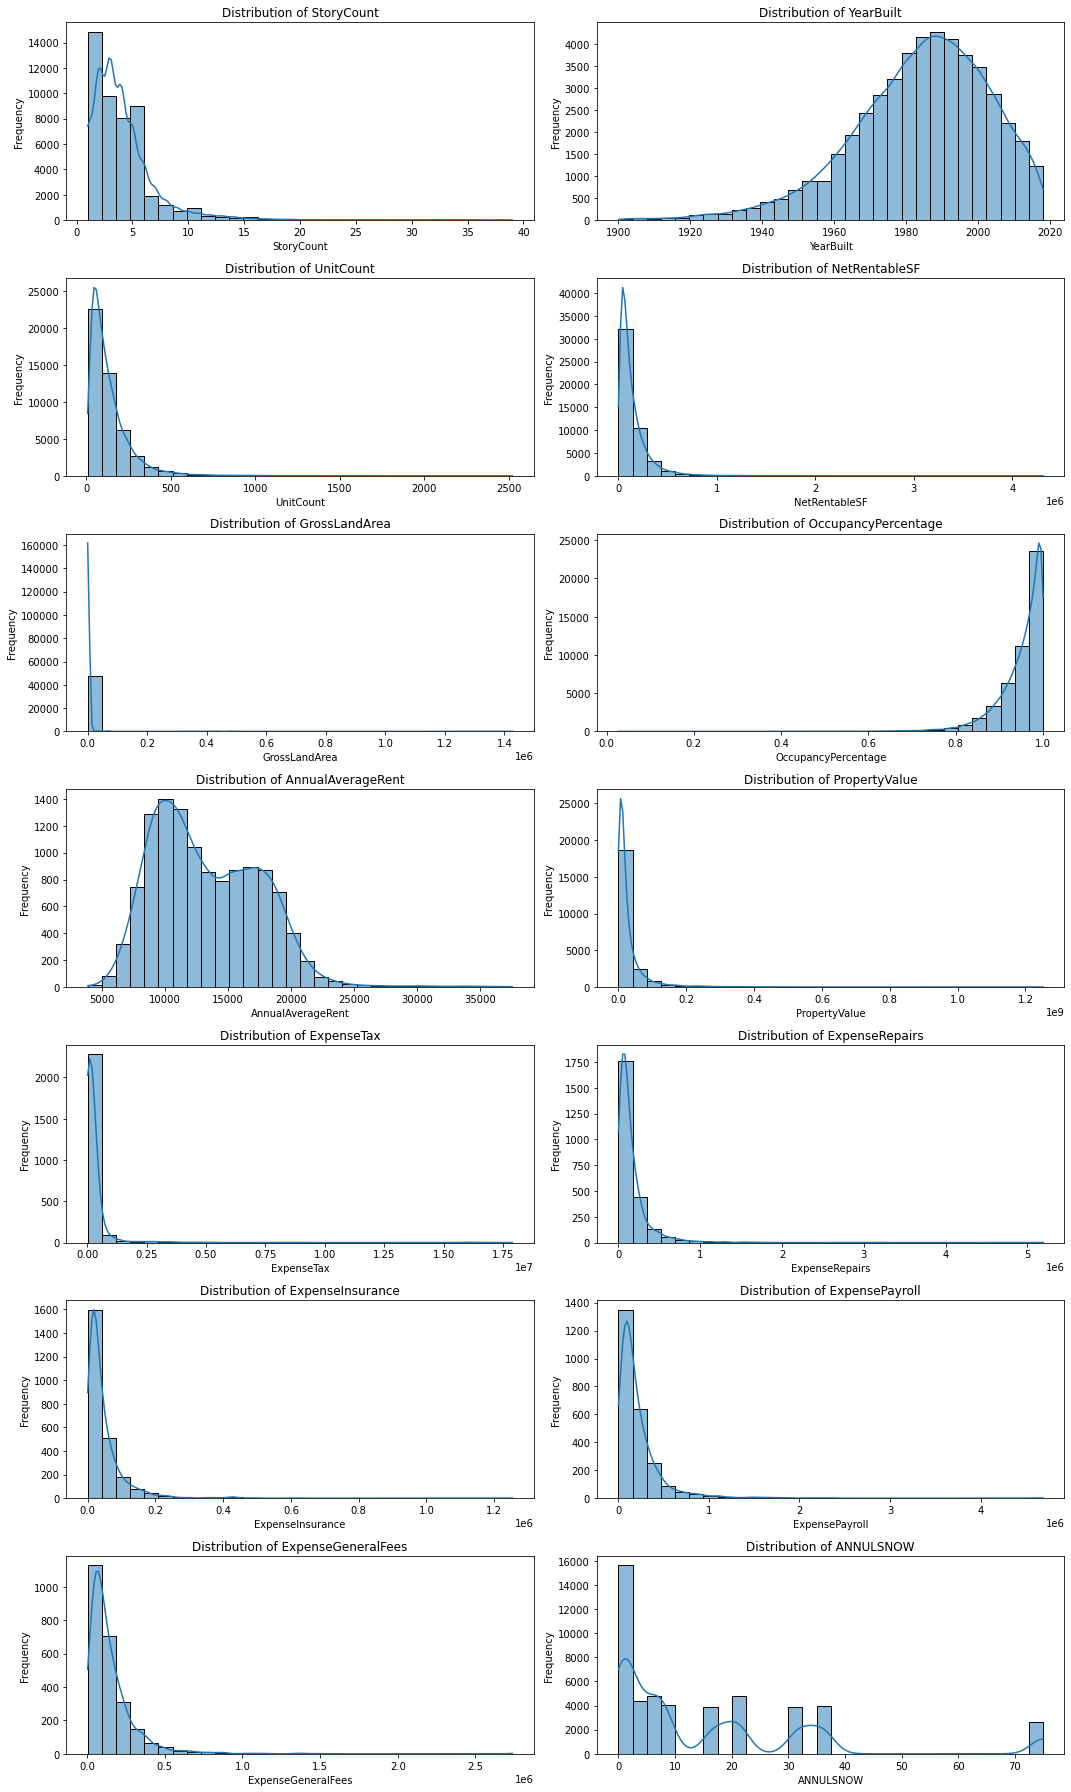

In [22]:
outlier_columns = ["StoryCount", "YearBuilt", "UnitCount", "NetRentableSF", "GrossLandArea","OccupancyPercentage", "AnnualAverageRent", "PropertyValue","ExpenseTax", "ExpenseRepairs", "ExpenseInsurance", "ExpensePayroll", "ExpenseGeneralFees", "ANNULSNOW"]
plt.figure(figsize=(15, 25))
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(7, 2, i)
    sns.histplot(master_data[col], kde=True,  bins=30)
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel("Frequency", fontsize=10)
plt.tight_layout()
plt.show()

In [23]:
def detect_outliers_normal(master_data, columns):
    outlier_summary = []

    for col in columns:
        # Calculate z-scores
        z_scores = np.abs((master_data[col] - master_data[col].mean()) / master_data[col].std())
        outliers = z_scores > 3
        
        # Calculate outlier count and percentage
        outlier_count = np.sum(outliers)
        total_count = len(master_data[col])
        outlier_percentage = (outlier_count / total_count) * 100
        
        # Store results in summary list
        outlier_summary.append({
            'Column': col,
            'Outlier Count': outlier_count,
            'Total Count': total_count,
            'Outlier Percentage': round(outlier_percentage, 2)
        })
    
    outlier_summary_df = pd.DataFrame(outlier_summary)
    return outlier_summary_df

columns_to_check = ['YearBuilt', 'AnnualAverageRent']
outlier_summary_df = detect_outliers_normal(master_data, columns_to_check)
outlier_summary_df

,Column,Outlier Count,Total Count,Outlier Percentage
0,YearBuilt,454,48019,0.95
1,AnnualAverageRent,63,48019,0.13


In [24]:
def detect_outliers_with_log(data, columns):
    outlier_summary = []

    for column in columns:
        # Apply log transformation (log1p to handle zeros safely)
        log_transformed = np.log1p(data[column])
        # Create a new column in the dataset with the log-transformed values
        data[f'{column}_log'] = log_transformed
        
        # Calculate IQR (Interquartile Range)
        Q1 = np.percentile(log_transformed, 25)
        Q3 = np.percentile(log_transformed, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Detect outliers based on IQR
        outliers = (log_transformed < lower_bound) | (log_transformed > upper_bound)
        outlier_count = np.sum(outliers)
        total_count = len(data[column])
        outlier_percentage = (outlier_count / total_count) * 100
        
        outlier_summary.append({
            'Column': column,
            'Outlier Count': outlier_count,
            'Total Count': total_count,
            'Outlier Percentage': round(outlier_percentage, 2)
        })

    outlier_summary_df = pd.DataFrame(outlier_summary)
    return outlier_summary_df, data

columns_to_check = [
    "StoryCount", "UnitCount", "NetRentableSF", 
    "GrossLandArea", "OccupancyPercentage", "AnnualAverageRent", 
    "PropertyValue", "ExpenseTax", "ExpenseRepairs", "ExpenseInsurance", 
    "ExpensePayroll", "ExpenseGeneralFees", "ANNULSNOW"
]

outlier_summary_df, updated_data = detect_outliers_with_log(master_data, columns_to_check)
outlier_summary_df

,Column,Outlier Count,Total Count,Outlier Percentage
0,StoryCount,758,48019,1.58
1,UnitCount,193,48019,0.40
2,NetRentableSF,276,48019,0.57
3,GrossLandArea,571,48019,1.19
4,OccupancyPercentage,2291,48019,4.77
5,AnnualAverageRent,0,48019,0.00
6,PropertyValue,0,48019,0.00
7,ExpenseTax,0,48019,0.00
8,ExpenseRepairs,0,48019,0.00
9,ExpenseInsurance,0,48019,0.00


Approach: Based on the distribution, I used z-score based approach to detect outliers for normally or nearly normally ditributed data and the second approach is applying log transform for highly skewed data and using IQR to do outlier detection. By this, we not only preserve important information but also will help the model generalise well.

I have decided to not remove the outliers because for our use-case in the field of real-estate there could be possibilites of properties with very high or low story count, number of units etc

In [25]:
updated_data.drop(columns = ["StoryCount", "UnitCount", "NetRentableSF", 
    "GrossLandArea", "OccupancyPercentage", "AnnualAverageRent", 
    "PropertyValue", "ExpenseTax", "ExpenseRepairs", "ExpenseInsurance", 
    "ExpensePayroll", "ExpenseGeneralFees", "ANNULSNOW"], inplace = True)

In [26]:
updated_data

,PropertyId,StateCode,BuildingCount,YearBuilt,YearLastRenovated,ParkingRatio,PropertyType,PropertySubType,SuccessProb,CPIALL,...,GrossLandArea_log,OccupancyPercentage_log,AnnualAverageRent_log,PropertyValue_log,ExpenseTax_log,ExpenseRepairs_log,ExpenseInsurance_log,ExpensePayroll_log,ExpenseGeneralFees_log,ANNULSNOW_log
0,1,0,2,1999,-1,Over 200%,Multifamily,Other,0.935606,218.705538,...,2.833213,0.575280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147
1,2,0,2,1991,-1,Between 150% and 200%,Multifamily,Other,0.999408,218.705538,...,2.666534,0.681186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.693147
2,3,0,2,1993,-1,Under 25%,Multifamily,Other,0.000049,218.705538,...,1.128171,0.661928,NaN,14.537842,NaN,NaN,NaN,NaN,NaN,0.693147
3,4,0,2,1973,-1,Between 25% and 150%,Multifamily,Other,0.972353,218.705538,...,0.506818,0.690954,9.711287,16.555282,11.140114,12.991034,11.660154,12.896671,10.268757,0.693147
4,5,0,2,2006,-1,Between 150% and 200%,Multifamily,Other,0.968561,218.705538,...,1.667707,0.692962,NaN,16.737651,NaN,NaN,NaN,NaN,NaN,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48014,59995,11,2,1995,-1,Under 25%,Multifamily,Other,0.999712,209.861941,...,3.663562,0.657381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.890372
48015,59996,11,3,1969,1976,Between 150% and 200%,Multifamily,Other,0.998809,209.861941,...,0.000000,0.640169,NaN,16.531482,NaN,NaN,NaN,NaN,NaN,2.890372
48016,59998,11,2,1997,2009,Over 200%,Multifamily,Other,0.988124,209.861941,...,2.302585,0.620695,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.890372
48017,59999,11,5,1965,-1,Between 25% and 150%,Multifamily,Other,0.651720,209.861941,...,0.000000,0.616987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.890372


Missing Value Analysis

In [27]:
def missing_val_analysis():
    missing_info = {} 
    for column in updated_data.columns:
        missing_count = updated_data[column].isnull().sum()
        if missing_count > 0:
            missing_percentage = missing_count / updated_data.shape[0]
            missing_info[column] = missing_count 
            print('"{}" has {:.2%} missing value percentage ({} missing records)'.format(column, missing_percentage, missing_count))
            
missing_vals = missing_val_analysis()

"AnnualAverageRent_log" has 74.99% missing value percentage (36010 missing records)
"PropertyValue_log" has 52.62% missing value percentage (25267 missing records)
"ExpenseTax_log" has 94.89% missing value percentage (45567 missing records)
"ExpenseRepairs_log" has 94.89% missing value percentage (45567 missing records)
"ExpenseInsurance_log" has 94.89% missing value percentage (45567 missing records)
"ExpensePayroll_log" has 94.89% missing value percentage (45567 missing records)
"ExpenseGeneralFees_log" has 94.89% missing value percentage (45567 missing records)


Based on our missing value analysis we can see that 7 columns have missing values. Out of which 5 features namely ExpenseTax, ExpenseRepairs, ExpenseInsurance, ExpensePayroll, ExpenseGeneralFees have missing values more than 90%, so it makes sense to drop them mainly because of 2 reasons:

    1. Insufficient data points for reliable imputation : There simply isn't enough data to accurately impute the missing values without introducing a signigficant bias.
    2. Unlikely Investment Drivers: Features with such sparse data are unlikely to contribute effectively and influence decision making.

We can further strengthen our hypothesis by performing correlation analysis as given below:

In [28]:
columns_to_check = ['AnnualAverageRent_log', 'PropertyValue_log', 'ExpenseTax_log','ExpenseRepairs_log', 'ExpenseInsurance_log', 'ExpensePayroll_log', 'ExpenseGeneralFees_log']

correlations = updated_data[columns_to_check + ['SuccessProb']].corr()['SuccessProb']

print("Correlation with Target Variable (SuccessProb):")
print(correlations.drop('SuccessProb').sort_values(ascending=False))

Correlation with Target Variable (SuccessProb):
AnnualAverageRent_log     0.338642
ExpenseTax_log            0.320296
PropertyValue_log         0.121601
ExpenseGeneralFees_log   -0.123356
ExpenseRepairs_log       -0.204136
ExpenseInsurance_log     -0.221381
ExpensePayroll_log       -0.224555
Name: SuccessProb, dtype: float64


Based on the correlation analysis results, we can make the following conclusions:

        1. Moderate Correlation: AnnualAverageRent (0.32) and PropertyValue (0.14) has moderate positive correlation with the target variable. Suggesting they are likely important for the prediction and should not be dropped.
        2. Weak Correlation: ExpenseTax is almost not related to the target and can be dropped without having an effect on the predictive power.
        3. Negative Correlation: ExpenseRepairs, ExpenseGeneralFees, ExpensePayroll, ExpenseInsurance have weak negative correaltion suggesting we these can also be dropped.


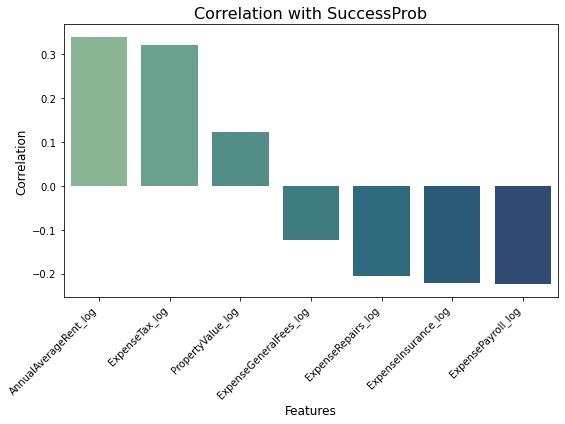

<Figure size 432x288 with 0 Axes>

In [29]:
correlations = correlations.drop('SuccessProb').sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='crest')

plt.title('Correlation with SuccessProb', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()
plt.savefig('corrwithtarget')

In [30]:
updated_data.drop(columns=['ExpenseTax_log','ExpenseRepairs_log', 'ExpenseInsurance_log', 'ExpensePayroll_log', 'ExpenseGeneralFees_log'], inplace=True)


In [31]:
updated_data

,PropertyId,StateCode,BuildingCount,YearBuilt,YearLastRenovated,ParkingRatio,PropertyType,PropertySubType,SuccessProb,CPIALL,...,SNOWDAYS,ANNULRAIN,StoryCount_log,UnitCount_log,NetRentableSF_log,GrossLandArea_log,OccupancyPercentage_log,AnnualAverageRent_log,PropertyValue_log,ANNULSNOW_log
0,1,0,2,1999,-1,Over 200%,Multifamily,Other,0.935606,218.705538,...,0,17,1.386294,4.510860,10.922066,2.833213,0.575280,NaN,NaN,0.693147
1,2,0,2,1991,-1,Between 150% and 200%,Multifamily,Other,0.999408,218.705538,...,0,17,1.609438,4.634729,11.791297,2.666534,0.681186,NaN,NaN,0.693147
2,3,0,2,1993,-1,Under 25%,Multifamily,Other,0.000049,218.705538,...,0,17,0.693147,3.135494,9.666007,1.128171,0.661928,NaN,14.537842,0.693147
3,4,0,2,1973,-1,Between 25% and 150%,Multifamily,Other,0.972353,218.705538,...,0,17,1.609438,4.828314,11.376337,0.506818,0.690954,9.711287,16.555282,0.693147
4,5,0,2,2006,-1,Between 150% and 200%,Multifamily,Other,0.968561,218.705538,...,0,17,1.609438,4.532599,11.713569,1.667707,0.692962,NaN,16.737651,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48014,59995,11,2,1995,-1,Under 25%,Multifamily,Other,0.999712,209.861941,...,5,47,1.609438,4.836282,11.995507,3.663562,0.657381,NaN,NaN,2.890372
48015,59996,11,3,1969,1976,Between 150% and 200%,Multifamily,Other,0.998809,209.861941,...,5,47,0.693147,3.951244,11.412040,0.000000,0.640169,NaN,16.531482,2.890372
48016,59998,11,2,1997,2009,Over 200%,Multifamily,Other,0.988124,209.861941,...,5,47,1.098612,4.110874,11.230337,2.302585,0.620695,NaN,NaN,2.890372
48017,59999,11,5,1965,-1,Between 25% and 150%,Multifamily,Other,0.651720,209.861941,...,5,47,1.791759,5.771441,12.894952,0.000000,0.616987,NaN,NaN,2.890372


In [32]:
propertyvalue = 'PropertyValue_log'
AnnualAverageRent = 'AnnualAverageRent_log'

# Create missingness indicators for propertyvalue and AnnualAverageRent
missing_propertyvalue = updated_data[propertyvalue].isnull().astype(int)
missing_AnnualAverageRent = updated_data[AnnualAverageRent].isnull().astype(int)

# MCAR Test (using correlation of missingness)
correlation = missing_propertyvalue.corr(missing_AnnualAverageRent)

# Structure the MCAR test results
mcar_results = {
    'correlation': correlation,
    'conclusion': 'MCAR' if correlation < 0.05 else 'MAR or MNAR',
    'reason': 'Low correlation between missingness patterns suggests MCAR.' 
              if correlation < 0.05 else 'High correlation between missingness patterns means MAR or MNAR.'
}

# MAR Test (missingness in one column depending on the other column's values)
results = {}

# Create missingness indicator for propertyvalue
missing_propertyvalue = updated_data[propertyvalue].isnull().astype(int)

# Test if missingness in propertyvalue is related to observed values in AnnualAverageRent
if master_data[AnnualAverageRent].dtype in [np.number]:
    # Numeric variables: t-test to check if missingness depends on the observed values of AnnualAverageRent
    missing_group = updated_data[updated_data[propertyvalue].isnull()][AnnualAverageRent]
    present_group = updated_data[~updated_data[propertyvalue].isnull()][AnnualAverageRent]
    t_stat, p_value = stats.ttest_ind(missing_group.dropna(), present_group.dropna(), equal_var=False)
    mar_test_results = {
        'statistic': t_stat,
        'p_value': p_value,
        'conclusion': 'Missingness is likely independent of the observed values.' if p_value > 0.05 else 'Missingness may depend on the observed values.'
    }
else:
    # Categorical variables: Chi-square test to check if missingness depends on the observed values of AnnualAverageRent
    contingency = pd.crosstab(missing_propertyvalue, master_data[AnnualAverageRent])
    chi2, p_value = stats.chi2_contingency(contingency)[:2]
    mar_test_results = {
        'statistic': chi2,
        'p_value': p_value,
        'conclusion': 'Missingness is likely independent of the observed values.' if p_value > 0.05 else 'Missingness may depend on the observed values.'
    }

results['mar'] = mar_test_results


In [33]:
final_results = {'mcar': mcar_results,'mar': results['mar']}

if final_results['mcar']['conclusion'] == 'MCAR' and final_results['mar']['p_value'] > 0.05:
    final_results['summary'] = 'The missing data is likely MCAR (Missing Completely at Random).'
else:
    final_results['summary'] = 'The missing data may be MAR (Missing at Random) or MNAR (Missing Not at Random).'

for test, result in final_results.items():
    if test != 'summary':
        print(f"\n{test.upper()} Test:")
        for key, value in result.items():
            print(f"  {key.capitalize()}: {value}")
    else:
        print(f"\nSummary: {result}")


MCAR Test:
  Correlation: 0.026964866575028917
  Conclusion: MCAR
  Reason: Low correlation between missingness patterns suggests MCAR.

MAR Test:
  Statistic: -1.4905013937927958
  P_value: 0.13611871834385209
  Conclusion: Missingness is likely independent of the observed values.

Summary: The missing data is likely MCAR (Missing Completely at Random).


Based on the above missingness pattern analysis, we can conclude that the missing values for AnnualAverageRent and PropertyValue are Missing Completly at Random so that gives us multiple options for imputation:

    1. KNN Imputation: Due to the MCAR nature of the data the the missing values are not systematically related to any variables and KNN can use the overall patterns in the data to make imputations.
    2. Simple Mean/Median Imputation: Due to it's randomness in the missing value, can choose between either based on the distribution.

In [34]:
updated_data.columns

Index(['PropertyId', 'StateCode', 'BuildingCount', 'YearBuilt',
       'YearLastRenovated', 'ParkingRatio', 'PropertyType', 'PropertySubType',
       'SuccessProb', 'CPIALL', 'MEDHHINC', 'MEDRENT', 'RECNO', 'MALMEDAGE',
       'FEMMEDAGE', 'ANC_TOTALS', 'PRCNTSUN', 'SKYHOURS', 'CLEARDAYS',
       'RAINDAYS', 'SNOWDAYS', 'ANNULRAIN', 'StoryCount_log', 'UnitCount_log',
       'NetRentableSF_log', 'GrossLandArea_log', 'OccupancyPercentage_log',
       'AnnualAverageRent_log', 'PropertyValue_log', 'ANNULSNOW_log'],
      dtype='object')

### Part 2: Feature Engineering and Visualizations

In [35]:
def create_year_built_bins(x):
    if pd.isna(x):
        return x
    x = int(x)
    
    # Equal width binning
    if 1900 <= x < 1925:
        return '1900-1924'
    if 1925 <= x < 1950:
        return '1925-1949'
    if 1950 <= x < 1975:
        return '1950-1974'
    if 1975 <= x < 2000:
        return '1975-1999'
    if 2000 <= x < 2020:
        return '2000-2019'
    else:
        return 'Others'

# Apply to the 'year_built' column
updated_data['YearBuilt_Bin'] = updated_data['YearBuilt'].apply(create_year_built_bins)
updated_data.drop(columns = ['YearBuilt'], inplace = True)

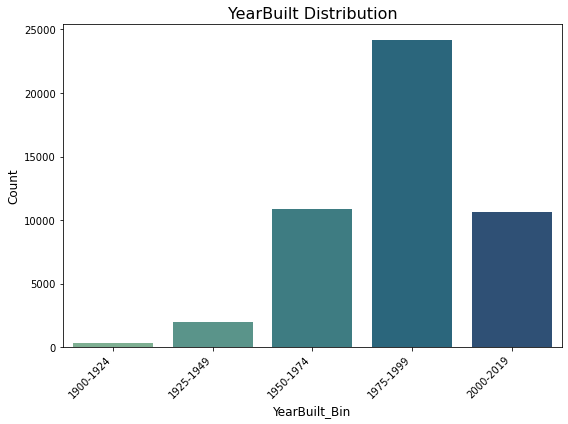

In [36]:
year_built_bin_counts = updated_data['YearBuilt_Bin'].value_counts()

ordered_bins = sorted(year_built_bin_counts.index, key=lambda x: x)

plt.figure(figsize=(8, 6))
sns.barplot(x=year_built_bin_counts.index, y=year_built_bin_counts.values, palette='crest', order=ordered_bins)

plt.title('YearBuilt Distribution', fontsize=16)
plt.xlabel('YearBuilt_Bin', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()



In [37]:
updated_data['PropertySubType'] = updated_data['PropertySubType'].replace({'co-op': 'Co-op' ,'COOP': 'Co-op', 'Co-Op': 'Co-op',})
updated_data['PropertySubType'] = updated_data['PropertySubType'].replace({'Student Housing': 'Student Housing','student housing': 'Student Housing', 'student_housing': 'Student Housing',})

Assumption: The above mentioned Property SubType are the same but with different spellings and write-up so for ease combining them.

The distribution of the target variable replicates that of beta distribution, with values between 0 an 1

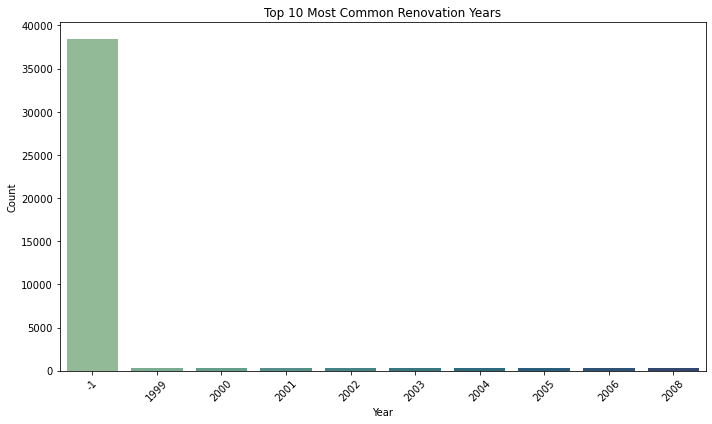

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x=updated_data['YearLastRenovated'].value_counts().nlargest(10).index, 
           y=updated_data['YearLastRenovated'].value_counts().nlargest(10).values,
           palette='crest')
plt.title('Top 10 Most Common Renovation Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Assumption: When dealing with YearLastRenovated column, I noticed that there are more than 38000+ data points having a placeholder value of '-1'. My assumption is that renovation never took place for those properties, hence does not make sense to drop it. My approach is to create another binary variable which indicates if it is renovated or not

In [39]:
# Create binary feature for never renovated
updated_data['NeverRenovated'] = (updated_data['YearLastRenovated'] == -1).astype(int)
updated_data = updated_data.drop('YearLastRenovated', axis=1)

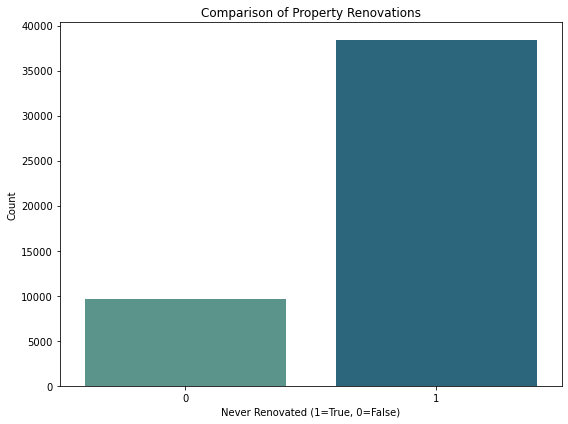

In [40]:
plt.figure(figsize=(8, 6))
sns.barplot(x=updated_data['NeverRenovated'].value_counts().index, 
           y=updated_data['NeverRenovated'].value_counts().values,
           palette='crest')
plt.title('Comparison of Property Renovations')
plt.xlabel('Never Renovated (1=True, 0=False)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

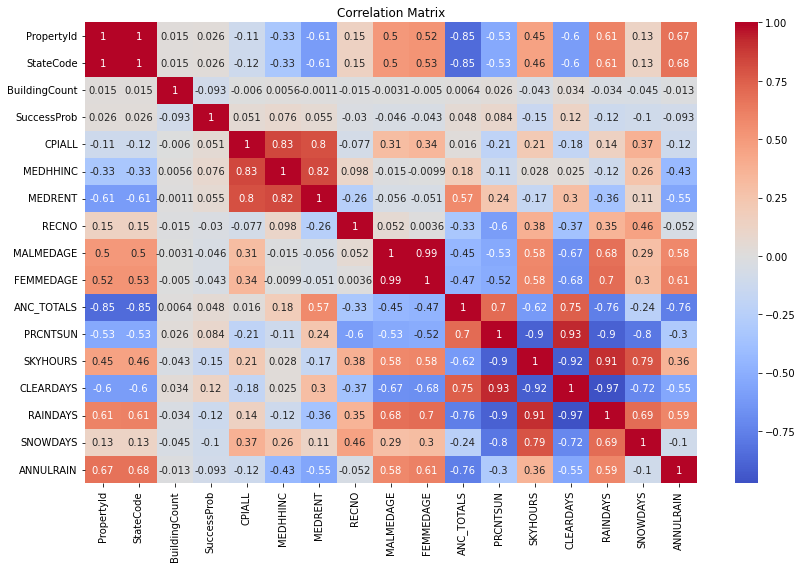

In [41]:
#2Correlation analysis for numerical variables

numerical_cols = [col for col in numerical_cols if col in updated_data.columns]

plt.figure(figsize=(12, 8))
correlation_matrix = updated_data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()



Based on the correlation plot, we can drop features having with correlation (< 0.03) with SuccessProb having minimal predicitve value: RECNO, PropertyId, Statecode.

We also drop values having correlation above 0.08. : SKYHOURS, FEMMEDAGE, CPIALL

In [42]:
updated_data.drop(columns = ['SKYHOURS', 'FEMMEDAGE', 'StateCode', 'CPIALL', 'RECNO', 'PropertyId'], inplace = True)

In [43]:
updated_data['AnnualAverageRent_log'].isnull().sum()

36010

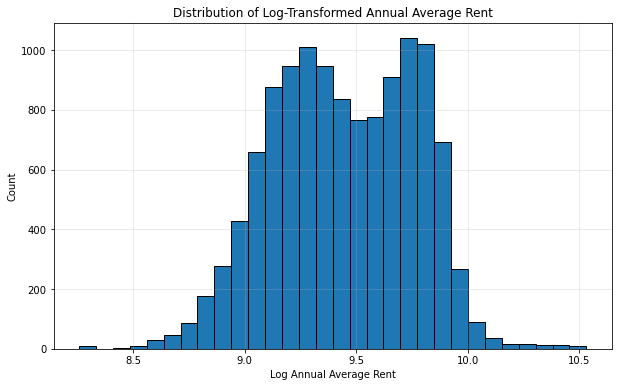

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(updated_data['AnnualAverageRent_log'], bins=30, edgecolor='black')
plt.title('Distribution of Log-Transformed Annual Average Rent')
plt.xlabel('Log Annual Average Rent')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

Given the bimodal distribution of Annual Average Rent as we can see in the histogram, median imputation would be better than mean since it's less affected by the two peaks. The mean would give us a value between the two bi-modal peaks, which doesn't represent either cluster well.

In [45]:
updated_data['AnnualAverageRent_log'] = updated_data['AnnualAverageRent_log'].fillna(updated_data['AnnualAverageRent_log'].median())

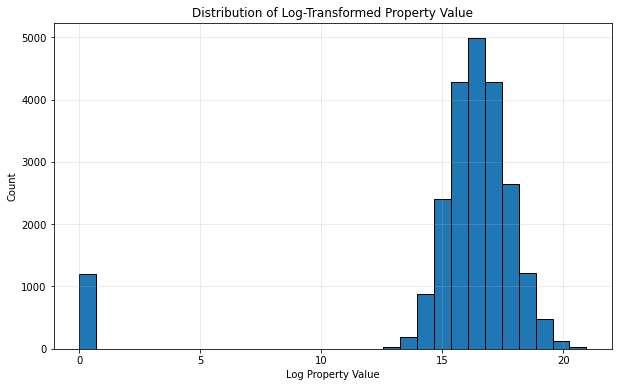

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(updated_data['PropertyValue_log'], bins=30, edgecolor='black')
plt.title('Distribution of Log-Transformed Property Value')
plt.xlabel('Log Property Value')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

In [47]:
updated_data['PropertyValue_log'].value_counts()

0.000000     1195
14.537842       1
17.475433       1
18.347976       1
19.128297       1
             ... 
17.016742       1
15.025997       1
15.564997       1
16.882083       1
16.531482       1
Name: PropertyValue_log, Length: 21558, dtype: int64

On futher studying the distribution, we see that around 1200 datapoints have 0 as the property value, which does not make sense, a property cannot be values as 0. So we drop such data points. Imputation would be misleading

In [48]:
# Drop rows where 'PropertyValue_log' is 0
updated_data = updated_data[updated_data['PropertyValue_log'] != 0]

In [49]:
updated_data['PropertyValue_log'] = updated_data['PropertyValue_log'].fillna(updated_data['PropertyValue_log'].median())

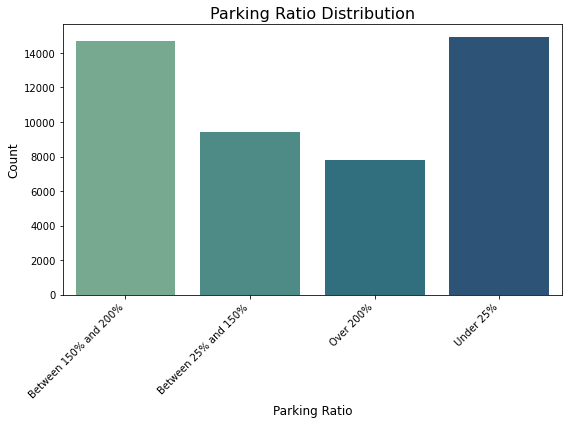

In [50]:
parkingratio_counts = updated_data['ParkingRatio'].value_counts()
ordered_bins = sorted(parkingratio_counts.index, key=lambda x: x)

plt.figure(figsize=(8, 6))
sns.barplot(x=parkingratio_counts.index, y=parkingratio_counts.values, palette='crest', order=ordered_bins)

plt.title('Parking Ratio Distribution', fontsize=16)
plt.xlabel('Parking Ratio', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


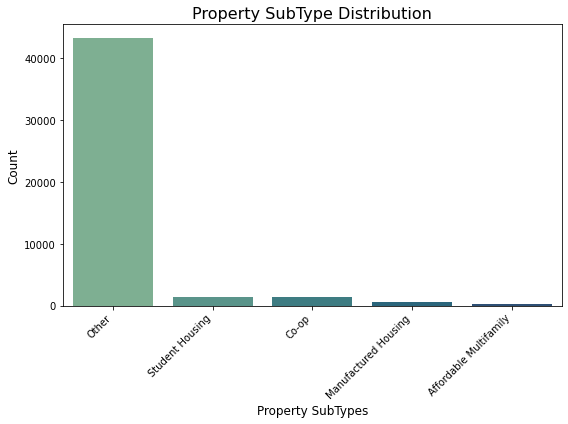

In [51]:
propstype_counts = updated_data['PropertySubType'].value_counts()
ordered_bins = sorted(propstype_counts.index, key=lambda x: x)

plt.figure(figsize=(8, 6))
sns.barplot(x=propstype_counts.index, y=propstype_counts.values, palette='crest')

plt.title('Property SubType Distribution', fontsize=16)
plt.xlabel('Property SubTypes', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

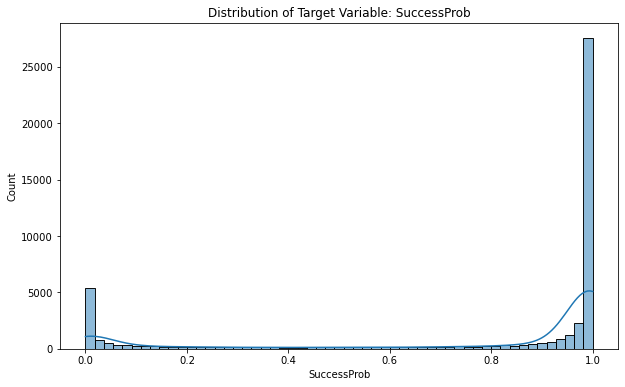


Target variable statistics:
count    48019.00
mean         0.77
std          0.38
min          0.00
25%          0.66
50%          0.99
75%          1.00
max          1.00
Name: SuccessProb, dtype: float64


In [52]:
# Distribution of target variable
target_column = 'SuccessProb'  
plt.figure(figsize=(10, 6))
sns.histplot(data=master_data, x=target_column, kde=True)
plt.title(f'Distribution of Target Variable: {target_column}')
plt.show()

print(f"\nTarget variable statistics:")
print(master_data[target_column].describe().round(2))

For this investment prediction, we can use either beta regression (suited for continuous targets between 0-1) or binary classification. Beta regression would preserve the success probability scores but requires complex modeling of the bimodal distribution and intuitively may not directly align with the investment decision-making process.

On the other hand, classification simplifies the problem by converting probabilities to binary outcomes (invest (1)/don't invest(0)), making it more actionable and appropriate for business decisions and easier to evaluate model performance. Given the binary nature of investment decisions and the strong bimodal distribution of the target variable, classification is more appropriate. 



### Part 3: Pre-modeling

In [53]:
updated_data.columns

Index(['BuildingCount', 'ParkingRatio', 'PropertyType', 'PropertySubType',
       'SuccessProb', 'MEDHHINC', 'MEDRENT', 'MALMEDAGE', 'ANC_TOTALS',
       'PRCNTSUN', 'CLEARDAYS', 'RAINDAYS', 'SNOWDAYS', 'ANNULRAIN',
       'StoryCount_log', 'UnitCount_log', 'NetRentableSF_log',
       'GrossLandArea_log', 'OccupancyPercentage_log', 'AnnualAverageRent_log',
       'PropertyValue_log', 'ANNULSNOW_log', 'YearBuilt_Bin',
       'NeverRenovated'],
      dtype='object')

In [54]:
binary_cols = ['NeverRenovated'] 
updated_data[binary_cols] = updated_data[binary_cols].astype('category')

numerical = updated_data.select_dtypes(exclude=['category', 'object'])
categorical = updated_data.select_dtypes(include=['category', 'object'])

categorical_columns = updated_data.select_dtypes(include=['category', 'object']).columns.to_list()
numerical_columns = updated_data.select_dtypes(exclude=['category', 'object']).columns.to_list()

In [55]:
numerical_columns

['BuildingCount',
 'SuccessProb',
 'MEDHHINC',
 'MEDRENT',
 'MALMEDAGE',
 'ANC_TOTALS',
 'PRCNTSUN',
 'CLEARDAYS',
 'RAINDAYS',
 'SNOWDAYS',
 'ANNULRAIN',
 'StoryCount_log',
 'UnitCount_log',
 'NetRentableSF_log',
 'GrossLandArea_log',
 'OccupancyPercentage_log',
 'AnnualAverageRent_log',
 'PropertyValue_log',
 'ANNULSNOW_log']

In [56]:
categorical_columns

['ParkingRatio',
 'PropertyType',
 'PropertySubType',
 'YearBuilt_Bin',
 'NeverRenovated']

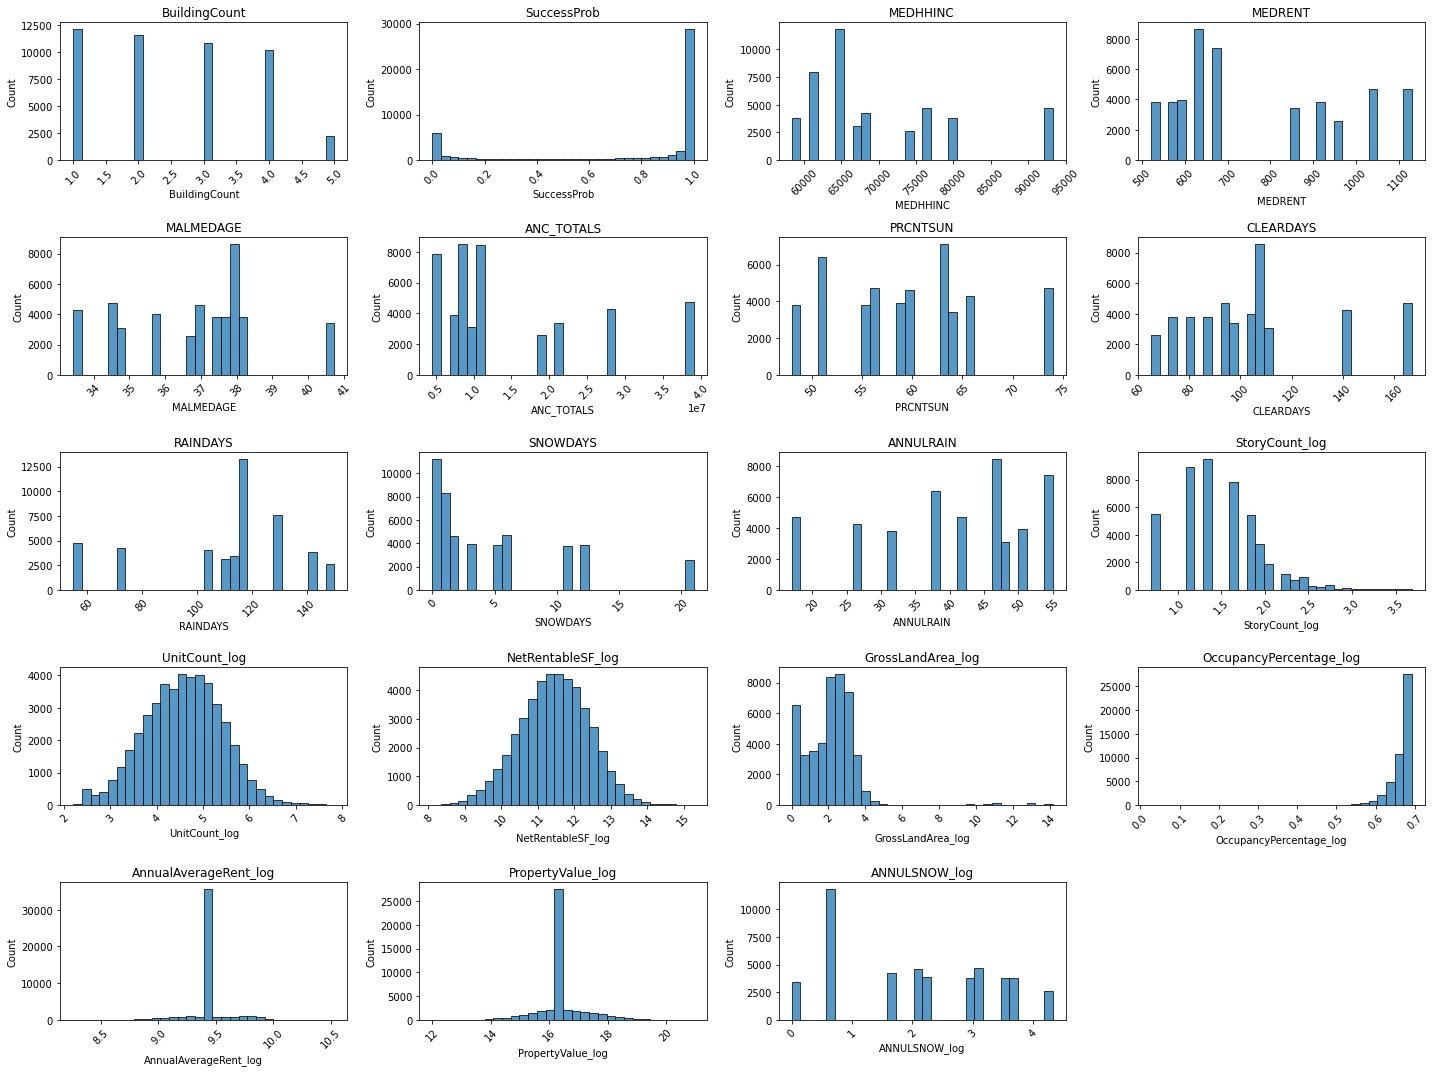

In [57]:
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical.columns, 1):
   plt.subplot(5, 4, i)
   sns.histplot(data=numerical[col], bins=30)
   plt.title(col)
   plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Based on the distributions shown, we need different scaling approaches: 

    1. StandardScaler for normally distributed features (UnitCount_log, NetRentableSF_log, GrossLandArea_log, MEDHHINC, MEDRENT) 
    2. RobustScaler for features with significant outliers (BuildingCount, ANC_TOTALS, SNOWDAYS, RAINDAYS, ANNULRAIN)
    3. MinMaxScaler for bounded or percentage-like features (OccupancyPercentage_log, PRCNTSUN, CLEARDAYS, MALMEDAGE). 
    4. Log-transformed features (PropertyValue_log, AnnualAverageRent_log, StoryCount_log, ANNULSNOW_log) don't require additional scaling as they're already normalized or well-distributed.

In [58]:
updated_data.isnull().sum()

BuildingCount              0
ParkingRatio               0
PropertyType               0
PropertySubType            0
SuccessProb                0
MEDHHINC                   0
MEDRENT                    0
MALMEDAGE                  0
ANC_TOTALS                 0
PRCNTSUN                   0
CLEARDAYS                  0
RAINDAYS                   0
SNOWDAYS                   0
ANNULRAIN                  0
StoryCount_log             0
UnitCount_log              0
NetRentableSF_log          0
GrossLandArea_log          0
OccupancyPercentage_log    0
AnnualAverageRent_log      0
PropertyValue_log          0
ANNULSNOW_log              0
YearBuilt_Bin              0
NeverRenovated             0
dtype: int64

In [59]:
categorical_columns = ['ParkingRatio', 'PropertySubType', 'YearBuilt_Bin']

# One-hot encode the categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' avoids dummy variable trap
encoded_data = encoder.fit_transform(updated_data[categorical_columns])

# Convert the encoded data to a DataFrame
encoded_df = pd.DataFrame(encoded_data, 
                          columns=encoder.get_feature_names_out(categorical_columns),
                          index=updated_data.index)

# Drop the original categorical columns and concatenate the encoded data
df_encoded = pd.concat([updated_data.drop(categorical_columns, axis=1), encoded_df], axis=1)

In [60]:
#splitting the data 80-20 split
X = df_encoded.drop('SuccessProb', axis=1)
y = df_encoded['SuccessProb']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
standard_features = ['UnitCount_log', 'NetRentableSF_log', 'GrossLandArea_log', 'MEDHHINC', 'MEDRENT']
robust_features = ['BuildingCount', 'ANC_TOTALS', 'SNOWDAYS', 'RAINDAYS', 'ANNULRAIN']
minmax_features = ['OccupancyPercentage_log', 'PRCNTSUN', 'CLEARDAYS', 'MALMEDAGE']

preprocessor = ColumnTransformer(transformers=[('standard', StandardScaler(), standard_features),('robust', RobustScaler(), robust_features),('minmax', MinMaxScaler(), minmax_features)],remainder='passthrough')
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [62]:
# Get the feature names after transformation
scaled_features = standard_features + robust_features + minmax_features
passthrough_features = [col for col in X_train.columns if col not in scaled_features]
all_feature_names = scaled_features + passthrough_features

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=all_feature_names, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=all_feature_names, index=X_test.index)

# Check the scaled DataFrame
(X_train_scaled_df.head())
(X_test_scaled_df.head())


,UnitCount_log,NetRentableSF_log,GrossLandArea_log,MEDHHINC,MEDRENT,BuildingCount,ANC_TOTALS,SNOWDAYS,RAINDAYS,ANNULRAIN,...,ParkingRatio_Over 200%,ParkingRatio_Under 25%,PropertySubType_Co-op,PropertySubType_Manufactured Housing,PropertySubType_Other,PropertySubType_Student Housing,YearBuilt_Bin_1925-1949,YearBuilt_Bin_1950-1974,YearBuilt_Bin_1975-1999,YearBuilt_Bin_2000-2019
41878,-0.678056,-0.325313,-0.284495,-0.8267,-0.719413,0.0,-0.445087,-0.2,-0.5,0.75,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
31749,0.026903,0.188597,0.748451,2.335578,1.311449,-0.333333,-0.172579,0.8,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
46627,0.316139,0.378173,-1.400669,-1.161404,-1.238074,0.333333,-0.470634,0.6,0.583333,0.3125,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
19465,0.675362,0.687121,0.353582,1.020651,0.726239,0.0,-0.123702,1.8,0.5,-0.625,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
36265,-1.365695,-0.84297,0.739923,-0.509755,-0.968083,-0.333333,0.037042,2.0,1.041667,-0.25,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


For this task for the numerical columns, we selected three scaling techniques based on the distributions: StandardScaler for normally distributed features like `UnitCount_log` and `NetRentableSF_log` to standardize around mean zero with unit variance, RobustScaler for features with significant outliers like `BuildingCount` and `ANC_TOTALS` since it uses quartiles instead of mean/std to reduce outlier impact, and MinMaxScaler for bounded or percentage-based features like `OccupancyPercentage_log` and `PRCNTSUN` to scale them to a 0-1 range while maintaining relative proportions.

In [63]:
X_train_scaled_df.drop(columns = ['PropertyType'], inplace = True)
X_test_scaled_df.drop(columns = ['PropertyType'], inplace = True)

Even though the `PropertyType` column shows a 0.76 correlation with the target variable, it only has one class, "Multifamily," across all rows in the dataset. This makes it a constant feature, meaning it doesn't provide any real variation or value for the model. The high correlation is likely due to the fact that every row is of this type, so it doesn't help the model make distinctions or improve predictions. For this reason, I think it's better to drop thecolumn since it doesn't contribute anything useful to the investment decision.

In [64]:
X_train_scaled_df

,UnitCount_log,NetRentableSF_log,GrossLandArea_log,MEDHHINC,MEDRENT,BuildingCount,ANC_TOTALS,SNOWDAYS,RAINDAYS,ANNULRAIN,...,ParkingRatio_Over 200%,ParkingRatio_Under 25%,PropertySubType_Co-op,PropertySubType_Manufactured Housing,PropertySubType_Other,PropertySubType_Student Housing,YearBuilt_Bin_1925-1949,YearBuilt_Bin_1950-1974,YearBuilt_Bin_1975-1999,YearBuilt_Bin_2000-2019
21592,1.194134,0.959047,-0.548428,1.020651,0.726239,1.0,-0.123702,1.8,0.5,-0.625,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
25928,-0.199055,-0.240213,-0.916462,-0.577463,-0.694652,0.0,0.0,0.0,0.041667,0.3125,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
47845,0.783241,0.835806,-0.453356,-1.161404,-1.238074,0.666667,-0.470634,0.6,0.583333,0.3125,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10101,0.984588,1.179144,-1.010941,0.438771,0.950587,0.0,0.60342,3.8,1.416667,-0.25,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4263,0.416523,0.297235,-0.763011,0.675929,1.811423,0.333333,2.165212,-0.4,-2.541667,-1.5625,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11593,-0.866576,-0.701886,-1.326229,0.438771,0.950587,-0.333333,0.60342,3.8,1.416667,-0.25,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
45874,-0.515183,0.372821,0.01272,-1.161404,-1.238074,0.0,-0.470634,0.6,0.583333,0.3125,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
39122,-0.27451,-1.407201,1.002879,-0.509755,-0.968083,-0.333333,0.037042,2.0,1.041667,-0.25,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
886,0.389968,-0.164579,0.849634,0.675929,1.811423,0.666667,2.165212,-0.4,-2.541667,-1.5625,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Part 4: Modeling

#### Logistic Regression

In [65]:
target_thresholds = [0.5, 0.66, 0.8, 0.99]

def calculate_metrics_for_target_threshold(y_train, y_test, y_pred_prob, thresholds):
    metrics = []
    for target_threshold in target_thresholds:
        y_train_binary = (y_train >= target_threshold).astype(int)
        y_test_binary = (y_test >= target_threshold).astype(int)
        
        log_reg_model = LogisticRegression(max_iter=1000)
        log_reg_model.fit(X_train_scaled_df, y_train_binary)
        y_pred_prob = log_reg_model.predict_proba(X_test_scaled_df)[:, 1]
        
        output_thresholds = np.linspace(0.1, 0.99, 100)
        for t in output_thresholds:
            y_pred = (y_pred_prob >= t).astype(int)
            
            TP = np.sum((y_pred == 1) & (y_test_binary == 1))
            FP = np.sum((y_pred == 1) & (y_test_binary == 0))
            FN = np.sum((y_pred == 0) & (y_test_binary == 1))
            TN = np.sum((y_pred == 0) & (y_test_binary == 0))
            
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            profit = (TP * 1_000_000) + (FN * -3_000_000) + (FP * -1_000_000)
            
            metrics.append({
                "Target Threshold": target_threshold,
                "Output Threshold": t,
                "Profit Earned": profit,
                "TP": TP,
                "FP": FP,
                "FN": FN,
                "TN": TN,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "Predictions": y_pred,
                "True Values": y_test_binary
            })
    
    return pd.DataFrame(metrics)

metrics_df = calculate_metrics_for_target_threshold(y_train, y_test, None, target_thresholds)

optimal_combination = metrics_df.loc[metrics_df["Profit Earned"].idxmax()]

print("\nOptimal Metrics:")
print(f"Target Threshold: {optimal_combination['Target Threshold']}")
print(f"Output Threshold: {optimal_combination['Output Threshold']}")
print(f"Profit Earned: ${optimal_combination['Profit Earned']:,.2f}")
print(f"Precision: {optimal_combination['Precision']:.4f}")
print(f"Recall: {optimal_combination['Recall']:.4f}")
print(f"F1 Score: {optimal_combination['F1']:.4f}")



Optimal Metrics:
Target Threshold: 0.5
Output Threshold: 0.27080808080808083
Profit Earned: $5,188,000,000.00
Precision: 0.7830
Recall: 0.9975
F1 Score: 0.8774


<Figure size 1080x720 with 0 Axes>

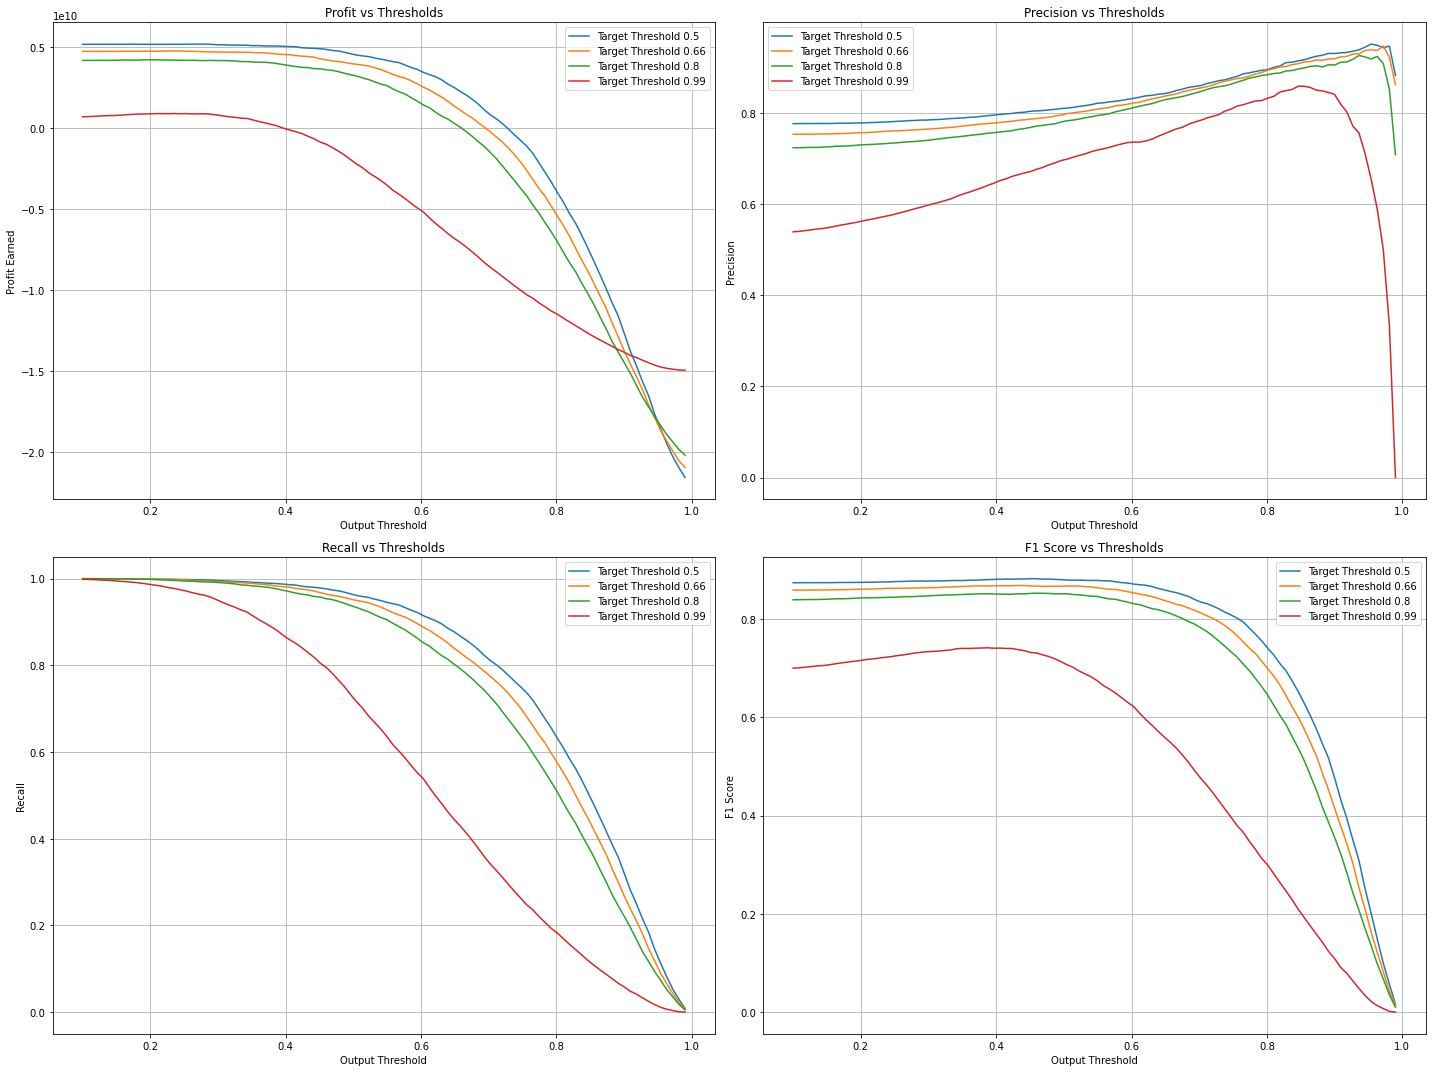


Detailed Metrics at Optimal Output Threshold:

Target Threshold: 0.5
Output Threshold: 0.2708
Profit: $5,188,000,000.00
Precision: 0.7830
Recall: 0.9975
F1 Score: 0.8774
TP: 7251, FP: 2009
FN: 18, TN: 87

Target Threshold: 0.66
Output Threshold: 0.2438
Profit: $4,763,000,000.00
Precision: 0.7602
Recall: 0.9976
F1 Score: 0.8629
TP: 7032, FP: 2218
FN: 17, TN: 98

Target Threshold: 0.8
Output Threshold: 0.1989
Profit: $4,220,000,000.00
Precision: 0.7298
Recall: 0.9982
F1 Score: 0.8432
TP: 6758, FP: 2502
FN: 12, TN: 93

Target Threshold: 0.99
Output Threshold: 0.2348
Profit: $898,000,000.00
Precision: 0.5728
Recall: 0.9773
F1 Score: 0.7223
TP: 4868, FP: 3631
FN: 113, TN: 753


In [66]:
plt.figure(figsize=(15, 10))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Profit
for target_threshold in target_thresholds:
    data = metrics_df[metrics_df["Target Threshold"] == target_threshold]
    ax1.plot(data["Output Threshold"], data["Profit Earned"], 
             label=f"Target Threshold {target_threshold}")
ax1.set_xlabel("Output Threshold")
ax1.set_ylabel("Profit Earned")
ax1.set_title("Profit vs Thresholds")
ax1.legend()
ax1.grid(True)

# Precision
for target_threshold in target_thresholds:
    data = metrics_df[metrics_df["Target Threshold"] == target_threshold]
    ax2.plot(data["Output Threshold"], data["Precision"], 
             label=f"Target Threshold {target_threshold}")
ax2.set_xlabel("Output Threshold")
ax2.set_ylabel("Precision")
ax2.set_title("Precision vs Thresholds")
ax2.legend()
ax2.grid(True)

# Recall
for target_threshold in target_thresholds:
    data = metrics_df[metrics_df["Target Threshold"] == target_threshold]
    ax3.plot(data["Output Threshold"], data["Recall"], 
             label=f"Target Threshold {target_threshold}")
ax3.set_xlabel("Output Threshold")
ax3.set_ylabel("Recall")
ax3.set_title("Recall vs Thresholds")
ax3.legend()
ax3.grid(True)

# F1 Score
for target_threshold in target_thresholds:
    data = metrics_df[metrics_df["Target Threshold"] == target_threshold]
    ax4.plot(data["Output Threshold"], data["F1"], 
             label=f"Target Threshold {target_threshold}")
ax4.set_xlabel("Output Threshold")
ax4.set_ylabel("F1 Score")
ax4.set_title("F1 Score vs Thresholds")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

# Print detailed metrics for each target threshold at optimal output threshold
print("\nDetailed Metrics at Optimal Output Threshold:")
for target_threshold in target_thresholds:
    data = metrics_df[metrics_df["Target Threshold"] == target_threshold]
    optimal_row = data.loc[data["Profit Earned"].idxmax()]
    
    print(f"\nTarget Threshold: {target_threshold}")
    print(f"Output Threshold: {optimal_row['Output Threshold']:.4f}")
    print(f"Profit: ${optimal_row['Profit Earned']:,.2f}")
    print(f"Precision: {optimal_row['Precision']:.4f}")
    print(f"Recall: {optimal_row['Recall']:.4f}")
    print(f"F1 Score: {optimal_row['F1']:.4f}")
    print(f"TP: {optimal_row['TP']}, FP: {optimal_row['FP']}")
    print(f"FN: {optimal_row['FN']}, TN: {optimal_row['TN']}")


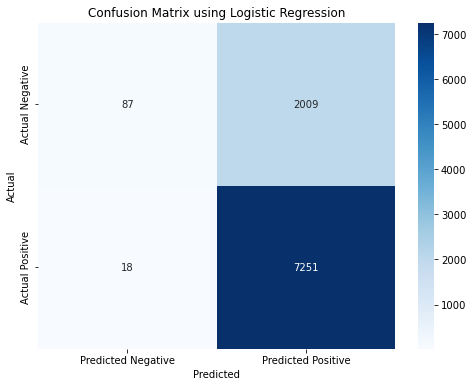

In [67]:
y_pred = (optimal_combination['Predictions'] >= optimal_combination['Output Threshold']).astype(int)
conf_matrix = confusion_matrix(optimal_combination['True Values'], y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix using Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

For modeling, we first use Logistic Regression with 3 objectives. Finding an optimal threshold, Good performance and maximum returns. So here we optlimize the thresholds for by evaluating different combinations of target and output thresholds. Initally, I tested several target thresholds (0.5, 0.66, 0.8, and 0.99), which convert the continuous SuccessProb variable into binary labels ( 0 or 1). For each of these target thresholds, it fits a logistic regression model and then explores 100 different output probability thresholds ranging from 0.1 to 0.99. 

At each combination of target and output thresholds, I calculate calculates key metrics, such as true positives, false positives, false negatives, true negatives, precision, recall, F1 score, and profit. The profit is calculated by assigning different costs to prediction errors: false negatives cost $3M, false positives cost $1M, and true positives earn $1M. This allows the model to find the best threshold combination that maximizes profit while considering the business's priorities, rather than just optimizing for traditional metrics like accuracy or F1 score. 

The ultimate goal is to select the threshold combination that balances error costs and maximizes the business’s return.

#### Random Forest

In [68]:
target_threshold = 0.5
y_train_binary = (y_train >= target_threshold).astype(int)  # Convert to binary (0 or 1)
y_test_binary = (y_test >= target_threshold).astype(int)

# 1. Train the Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_df, y_train_binary)

y_pred_prob_rf = rf_model.predict_proba(X_test_scaled_df)[:, 1]

def calculate_profit(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    profit = (TP * 1_000_000) + (FN * -3_000_000) + (FP * -1_000_000)
    return profit

# 4. Explore different target thresholds to classify as successful or unsuccessful
target_thresholds = np.linspace(0.1, 0.99, 100)
profits_rf = []

for threshold in target_thresholds:
    # Apply the threshold to predict binary outcomes (1 for success, 0 for failure)
    y_pred_rf = (y_pred_prob_rf >= threshold).astype(int)
    
    # Calculate profit for this threshold
    profit_rf = calculate_profit(y_test_binary, y_pred_rf)
    profits_rf.append(profit_rf)

# 5. Find the optimal target threshold that maximizes profit
optimal_target_threshold_rf = target_thresholds[np.argmax(profits_rf)]

# 6. Print out the optimal threshold and corresponding profit
print(f"Optimal Target Threshold (Random Forest): {optimal_target_threshold_rf}")
print(f"Maximized Profit Earned (Random Forest): ${profits_rf[np.argmax(profits_rf)]:,.2f}")

y_pred_prob_rf_train = rf_model.predict_proba(X_train_scaled_df)[:, 1]
y_pred_rf_train_optimal = (y_pred_prob_rf_train >= optimal_target_threshold_rf).astype(int)
train_precision_rf = precision_score(y_train_binary, y_pred_rf_train_optimal)

print(f"Train Precision (Random Forest): {train_precision_rf:.4f}")

y_pred_rf_optimal = (y_pred_prob_rf >= optimal_target_threshold_rf).astype(int)
test_precision_rf = precision_score(y_test_binary, y_pred_rf_optimal)
test_cm_rf = confusion_matrix(y_test_binary, y_pred_rf_optimal)

print(f"Test Precision (Random Forest): {test_precision_rf:.4f}")

Optimal Target Threshold (Random Forest): 0.11797979797979799
Maximized Profit Earned (Random Forest): $5,179,000,000.00
Train Precision (Random Forest): 0.7910
Test Precision (Random Forest): 0.7767


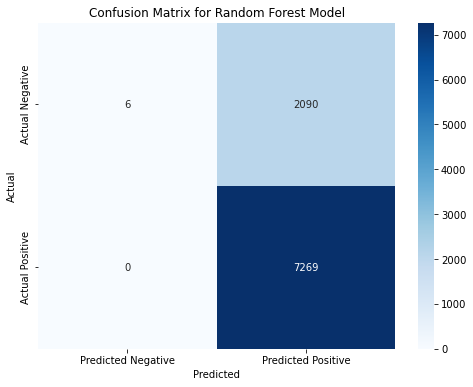

In [69]:
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix for Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

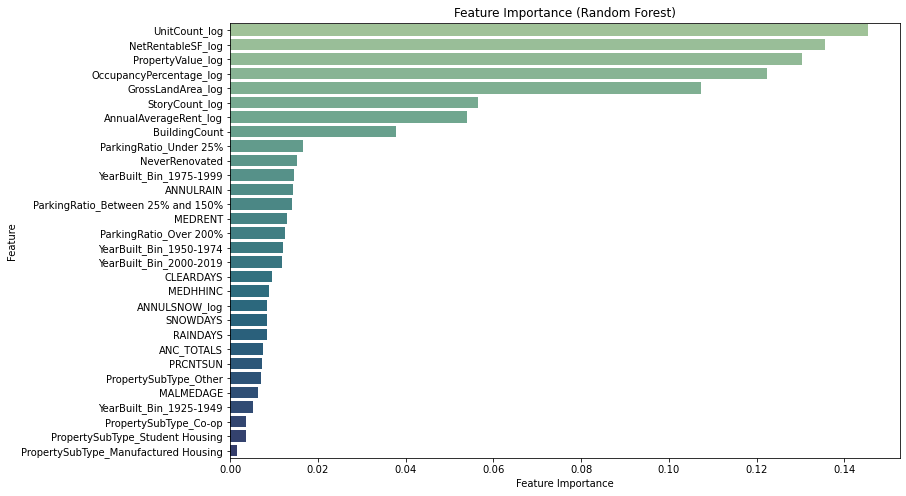

In [70]:
feature_importance = rf_model.feature_importances_

indices = np.argsort(feature_importance)[::-1]
sorted_features = X_train_scaled_df.columns[indices]

plt.figure(figsize=(12, 8))
sns.barplot(
    y=sorted_features, 
    x=feature_importance[indices], 
    palette='crest', 
    orient='h' 
)

plt.title("Feature Importance (Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")

plt.show()


#### XGBoost

In [89]:
X_train_array = X_train_scaled_df.to_numpy()
X_test_array = X_test_scaled_df.to_numpy()

# Convert to binary based on initial threshold
initial_threshold = 0.5
y_train_binary = (y_train >= initial_threshold).astype(int)
y_test_binary = (y_test >= initial_threshold).astype(int)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Fit the model
xgb_model.fit(
    X_train_array, 
    y_train_binary,
    eval_set=[(X_test_array, y_test_binary)],
    verbose=100
)

# Get probability predictions
y_pred_prob_xgb = xgb_model.predict_proba(X_test_array)[:, 1]

# Define profit calculation function
def calculate_profit(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TP = cm[1, 1]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    profit = (TP * 1_000_000) + (FN * -3_000_000) + (FP * -1_000_000)
    return profit

# Explore different thresholds
output_thresholds = np.linspace(0.1, 0.99, 100)
profits_xgb = []

for threshold in output_thresholds:
    # Apply threshold to predict binary outcomes
    y_pred_xgb = (y_pred_prob_xgb >= threshold).astype(int)
    
    # Calculate profit for this threshold
    profit_xgb = calculate_profit(y_test_binary, y_pred_xgb)
    profits_xgb.append(profit_xgb)

# Find optimal threshold
optimal_threshold_xgb = output_thresholds[np.argmax(profits_xgb)]

# Print results
#print(f"Optimal Threshold (XGBoost): {optimal_threshold_xgb:.4f}")
print(f"Maximized Profit (XGBoost): ${profits_xgb[np.argmax(profits_xgb)]:,.2f}")

# Calculate train metrics at optimal threshold
y_pred_prob_xgb_train = xgb_model.predict_proba(X_train_array)[:, 1]
y_pred_xgb_train_optimal = (y_pred_prob_xgb_train >= optimal_threshold_xgb).astype(int)
train_precision_xgb = precision_score(y_train_binary, y_pred_xgb_train_optimal)
print(f"Train Precision (XGBoost): {train_precision_xgb:.4f}")

# Calculate test metrics at optimal threshold
y_pred_xgb_optimal = (y_pred_prob_xgb >= optimal_threshold_xgb).astype(int)
test_precision_xgb = precision_score(y_test_binary, y_pred_xgb_optimal)
test_cm_xgb = confusion_matrix(y_test_binary, y_pred_xgb_optimal)
print(f"Test Precision (XGBoost): {test_precision_xgb:.4f}")
#print(f"Test Confusion Matrix (XGBoost):\n{test_cm_xgb}")
#print(f"Maximized Profit (XGBoost): ${optimal_profit:,.2f}")



[0]	validation_0-logloss:0.65282
[99]	validation_0-logloss:0.43173
Maximized Profit (XGBoost): $5,173,000,000.00
Train Precision (XGBoost): 0.7774
Test Precision (XGBoost): 0.7771


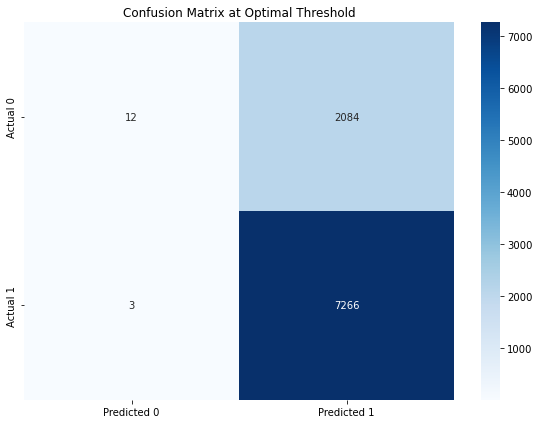

In [87]:
# Plot 3: Confusion Matrix
plt.figure(figsize=(8, 6))

sns.heatmap(test_cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for XGBoost')

plt.tight_layout()
plt.show()


In [85]:
# Calculate and print additional metrics
TP = test_cm_xgb[1, 1]
FP = test_cm_xgb[0, 1]
FN = test_cm_xgb[1, 0]
TN = test_cm_xgb[0, 0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
accuracy = (TP + TN) / (TP + TN + FP + FN)

print("\nDetailed Metrics at Optimal Threshold:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")
print(f"True Negatives: {TN}")


Detailed Metrics at Optimal Threshold:
Accuracy: 0.7771
Precision: 0.7771
Recall: 0.9996
F1 Score: 0.8744
True Positives: 7266
False Positives: 2084
False Negatives: 3
True Negatives: 12


Based on the results, all three models perform quite similarly, but Logistic Regression edges out as the best performer when considering both precision and profit metrics. It achieved the highest profit at $5,188M, slightly better than Random Forest ($5,179M) and XGBoost ($5,173M). In terms of precision, Random Forest achieved the highest training precision (0.7910) while Logistic Regression showed strong precision (0.7830) with exceptional recall (0.9975). The high recall combined with good precision for Logistic Regression suggests it's most effective at identifying successful cases while minimizing costly false negatives. When considering the balance between profit maximization and predictive accuracy, Logistic Regression appears to be the optimal choice for this investment task.